In [92]:
import pandas as pd
import numpy as np
from ipynb.fs.full.extracao import damage_matrix, Types, pokedex_df_filtered
import matplotlib.pyplot as plt
from imageio.v2 import imread
from mpl_toolkits.axes_grid1 import ImageGrid
pokedex_df_filtered_with_predict = pd.read_pickle('./pokedex_df_filtered_with_predict.pkl')

# Gerador de times

Agora iremos arrumar um jeito de encontrar um Pokemon com o tipo complementar ao meu Pokemon incial e montar o time baseado na nossa "role" de batalha gerada no outro notebook.

Sabendo quais as fraquezas e efetividades do meu pokemon, irei buscar:
- 2 pokemons imunes (ou resistentes) as fraquezas do meu inicial. Irei escolher as fraquezes que são mais usadas no competitivo.
- 3 pokemons superefetivos contra as fraquezas do meu inicial. Irei escolher as fraquezes que são mais usadas no competitivo.

Irei usar algum critério randomico para escolher tipos diferents para essas duas categorias e gerar mais de uma opção de time.  
Por exemplo, para o Charizard posso escolher 3 Pokemons imunes aos tipos:
- Water
- Ground
- Ice  

ou

- Rock
- Eletric
- Water

## Implementando

In [93]:
def plot_teams(teams):
    fig = plt.figure(figsize=(12., 10.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(len(teams), 6),  # creates 2x2 grid of axes
                     axes_pad=0.2,  # pad between axes in inch.
                     )

    cnt = 0
    for team_idx in range(len(teams)):

        for i, pokemon in teams[team_idx].iterrows():
            image_url = pokemon["image_url"]
            image_file = imread(image_url)
            name = pokemon["name"]
            role = pokemon["role"]
            grid[cnt].text(10, 5, role, bbox={'facecolor': 'white', 'pad': 1})
            grid[cnt].imshow(image_file)
            cnt += 1

    plt.show()

In [94]:
def choose_mon(type_choices_ordered_by_weight, desired_role, actual_team):
    for type_choice in type_choices_ordered_by_weight:
        valid_mons = pokedex_df_filtered_with_predict[(pokedex_df_filtered_with_predict.role == desired_role) & (pokedex_df_filtered.type1 == Types(type_choice).name)]
        valid_mons = valid_mons[~valid_mons.name.isin(actual_team.name.values) ]
        if len(valid_mons) > 0:
            return valid_mons.sample(1)
        else:
            valid_mons = pokedex_df_filtered_with_predict[(pokedex_df_filtered_with_predict.role == desired_role) & (pokedex_df_filtered.type2 == Types(type_choice).name)]
            valid_mons = valid_mons[~valid_mons.name.isin(actual_team.name.values)]
            if len(valid_mons) > 0:
                return valid_mons.sample(1)

    # se não tiver um pkmn na classe desejada
    roles = np.array(['tank' ,'tank', 'attacker', 'attacker', 'spattacker', 'spattacker'])
    np.random.shuffle(roles)
    for role_choice in roles:
        for type_choice in type_choices_ordered_by_weight:
            valid_mons = pokedex_df_filtered_with_predict[(pokedex_df_filtered_with_predict.role == role_choice) & (pokedex_df_filtered.type1 == Types(type_choice).name)]
            if len(valid_mons) > 0:
                return valid_mons.sample(1)

def generate_team(pokemon_name):
    pokemon = pokedex_df_filtered_with_predict[pokedex_df_filtered_with_predict.name == pokemon_name]
    team = pokemon
    pokemon_role = pokemon.role.values[0]
    desired_roles = np.array(['tank' ,'tank', 'attacker', 'attacker', 'spattacker', 'spattacker'])
    desired_roles = np.delete(desired_roles, np.where(desired_roles == pokemon_role)[0][0])

    desired_defensive_roles = desired_roles[:2]
    desired_offensive_roles = desired_roles[2:]

    rng = np.random.default_rng()
    type1 = Types[pokemon.type1.values[0]]
    type2 = pokemon.type2.values[0]

    pokemon_types = [type1]
    if type2 is not None:
        pokemon_types.append(Types[type2])

    damage_multipliers = np.empty(18)
    damage_multipliers.fill(1)
    for cur_type in pokemon_types:
        damage_multipliers_def = damage_matrix[:, cur_type.value]
        for i in range(len(damage_multipliers_def)):
            damage_multipliers[i] = damage_multipliers[i] * damage_multipliers_def[i]



    four_x_weak = np.argwhere(damage_multipliers == 4).flatten() ## Tipos que meu pokemon recebe 4x mais dano nos ataques
    two_x_weak = np.argwhere(damage_multipliers == 2).flatten() ## Tipos que meu pokemon recebe 2x mais dano nos ataques

    if len(four_x_weak) == 2:
        weak_types = np.concatenate([rng.choice(four_x_weak, size = 2, replace=False)])
    elif len(four_x_weak) == 1:
        weak_types = np.concatenate([rng.choice(four_x_weak, size = 1, replace=False), rng.choice(two_x_weak, size = 1, replace=False)])
    else:
        if len(two_x_weak) == 1:
            weak_types = [two_x_weak[0], two_x_weak[0]]
        else:
            weak_types = np.concatenate([rng.choice(two_x_weak, size = 2, replace=False)])

    print(f"Pokemons defensivos devem ser resistentes contra: {[Types(i).name for i in weak_types]}")
    for i in range(len(weak_types)):
        damage_multiplier_def = damage_matrix[weak_types[i]]
        immune_to = np.argwhere(damage_multiplier_def == 0.0).flatten()
        rng.shuffle(immune_to)
        resistent_to = np.argwhere(damage_multiplier_def == 0.5).flatten()
        rng.shuffle(resistent_to)

        type_choices_ordered_by_weight = np.concatenate([immune_to, resistent_to])

        chosed_mon = choose_mon(type_choices_ordered_by_weight, desired_defensive_roles[i], team)
        team = pd.concat([team, chosed_mon])


    if len(four_x_weak) == 2:
        weak_types = np.concatenate([rng.choice(four_x_weak, size = 2, replace=False), rng.choice(two_x_weak, size = 1, replace=False)])
    elif len(four_x_weak) == 1:
        if len(two_x_weak) == 1:
            weak_types = np.concatenate([rng.choice(four_x_weak, size = 1, replace=False), np.array([two_x_weak[0], two_x_weak[0]])])
        else:
            weak_types = np.concatenate([rng.choice(four_x_weak, size = 1, replace=False), rng.choice(two_x_weak, size = 2, replace=False)])
    else:
        if len(two_x_weak) == 1:
            weak_types = np.array([two_x_weak[0], two_x_weak[0], two_x_weak[0]])
        elif len(two_x_weak) == 2:
            weak_types = np.array([two_x_weak[0], two_x_weak[0], two_x_weak[1]])
        else:
            weak_types = np.concatenate([rng.choice(two_x_weak, size = 3, replace=False)])


    print(f"Pokemons ofensivos devem ser fortes contra: {[Types(i).name for i in weak_types]}")
    for i in range(len(weak_types)):
        damage_multiplier_atk = damage_matrix[:, weak_types[i]]
        strong_against = np.argwhere(damage_multiplier_atk == 2.).flatten()
        rng.shuffle(strong_against)

        chosed_mon = choose_mon(strong_against, desired_offensive_roles[i], team)
        team = pd.concat([team, chosed_mon])

    return team

Pokemons defensivos devem ser resistentes contra: ['bug', 'dark']
Pokemons ofensivos devem ser fortes contra: ['bug', 'dark', 'ghost']
Pokemons defensivos devem ser resistentes contra: ['dark', 'ghost']
Pokemons ofensivos devem ser fortes contra: ['ghost', 'dark', 'bug']
Pokemons defensivos devem ser resistentes contra: ['dark', 'bug']
Pokemons ofensivos devem ser fortes contra: ['bug', 'ghost', 'dark']
Pokemons defensivos devem ser resistentes contra: ['dark', 'ghost']
Pokemons ofensivos devem ser fortes contra: ['ghost', 'bug', 'dark']


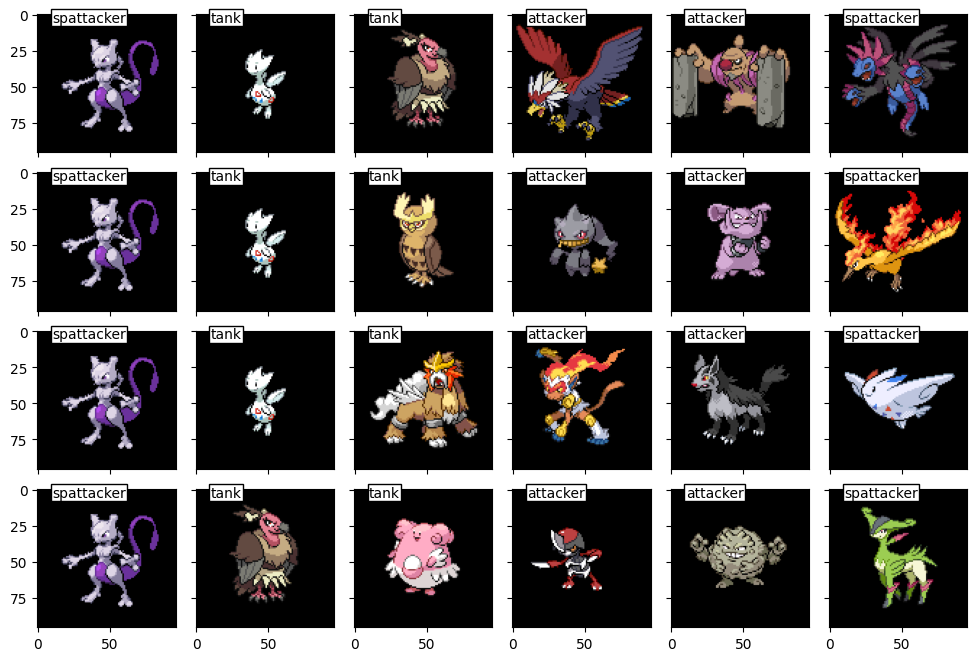

In [101]:
teams = []
for i in range(4):
    teams.append(generate_team("mewtwo"))
plot_teams(teams)
## TODO: capturar cobertura de superefetivos/fraquezas de cada time e passar por um modelo para checar qual é o melhor
## TODO: pegar apenas pokemons na sua última forma